In [1]:
import sys
import os
import pickle

sys.path.append("../..")
                                                                                                                                                                                                                                                    
import matplotlib.pyplot as plt
import plotly.io as pio
from tqdm.auto import tqdm, trange
import torch

from ray_tools.hist_optimizer.hist_optimizer import *
from ray_tools.base.engine import RayEngine
from ray_optim.plot import Plot
from ray_tools.base.parameter import MutableParameter
from ray_nn.nn.xy_hist_data_models import HistSurrogateEngine, Model, StandardizeXYHist
from ray_tools.base.backend import RayBackendDockerRAYUI

seed = 1000042
torch.manual_seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
file_root = '../../'
outputs_dir = os.path.join(file_root, 'outputs/')
engine = RayEngine(rml_basefile=os.path.join(file_root,'rml_src/METRIX_U41_G1_H1_318eV_PS_MLearn_1.15.rml'),
                                exported_planes=["ImagePlane"],
                                ray_backend=RayBackendDockerRAYUI(docker_image='ray-ui-service',
                                                                  docker_container_name='ray-ui-service-test',
                                                                  dockerfile_path=os.path.join(file_root, 'ray_docker/rayui'),
                                                                  ray_workdir='/dev/shm/ray-workdir',
                                                                  verbose=False),
                                num_workers=-1,
                                as_generator=False)


model_path = os.path.join(file_root, "outputs/xy_hist/s021yw7n/checkpoints/epoch=235-step=70000000.ckpt")
surrogate_engine = HistSurrogateEngine(checkpoint_path=model_path)

model = Model(path=model_path)

Sequential(
  (0): Linear(in_features=35, out_features=70, bias=True)
  (1): Mish()
  (2): Linear(in_features=70, out_features=74, bias=True)
  (3): Mish()
  (4): Linear(in_features=74, out_features=78, bias=True)
  (5): Mish()
  (6): Linear(in_features=78, out_features=83, bias=True)
  (7): Mish()
  (8): Linear(in_features=83, out_features=88, bias=True)
  (9): Mish()
  (10): Linear(in_features=88, out_features=94, bias=True)
  (11): Mish()
  (12): Linear(in_features=94, out_features=100, bias=True)
  (13): Sigmoid()
)
Sequential(
  (0): Linear(in_features=35, out_features=70, bias=True)
  (1): Mish()
  (2): Linear(in_features=70, out_features=74, bias=True)
  (3): Mish()
  (4): Linear(in_features=74, out_features=78, bias=True)
  (5): Mish()
  (6): Linear(in_features=78, out_features=83, bias=True)
  (7): Mish()
  (8): Linear(in_features=83, out_features=88, bias=True)
  (9): Mish()
  (10): Linear(in_features=88, out_features=94, bias=True)
  (11): Mish()
  (12): Linear(in_features=9

In [3]:
offsets_selected, uncompensated_parameters_selected, compensated_parameters_selected = find_good_offset_problem(model, fixed_parameters = [8, 14, 20, 21, 27, 28, 34], seed=seed)

with torch.no_grad():
    observed_rays = model(compensated_parameters_selected)

# Examine best optimizer

In [4]:
loss_min_params, loss, loss_min_list = optimize_evotorch_ga(model, observed_rays, uncompensated_parameters_selected, iterations=1000, num_candidates=500, mutation_scale=0.2, sbx_crossover_rate=0.8, tournament_size=3, seed=seed)

Evotorch Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
fig = fancy_plot_param_tensors(loss_min_params[:], uncompensated_parameters_selected[:].squeeze(), engine = engine, ray_parameter_container=model.input_parameter_container, compensated_parameters=compensated_parameters_selected[:].squeeze())
pio.write_html(fig, os.path.join(outputs_dir,'fancy.html'))

In [21]:
loss_min_ray_outputs = simulate_param_tensor(loss_min_params[:, :], engine, model.input_parameter_container, exported_plane='ImagePlane')
reference_ray_outputs = simulate_param_tensor(compensated_parameters_selected[:, :].squeeze(-2), engine, model.input_parameter_container, exported_plane='ImagePlane')
reference_ray_outputs_2 = simulate_param_tensor(compensated_parameters_selected[:, :].squeeze(-2), engine, model.input_parameter_container, exported_plane='ImagePlane')

out = compare_with_reference(reference_ray_outputs, loss_min_ray_outputs)
print("deviation best to ref", out[0].item(), "±", out[1].item())
out = compare_with_reference(reference_ray_outputs, reference_ray_outputs_2)
print("deviation ref to ref", out[0].item(), "±", out[1].item())

deviation best to ref 0.0006671940791420639 ± 0.00019371126836631447
deviation ref to ref 2.030230825766921e-05 ± 3.0050288842176087e-05


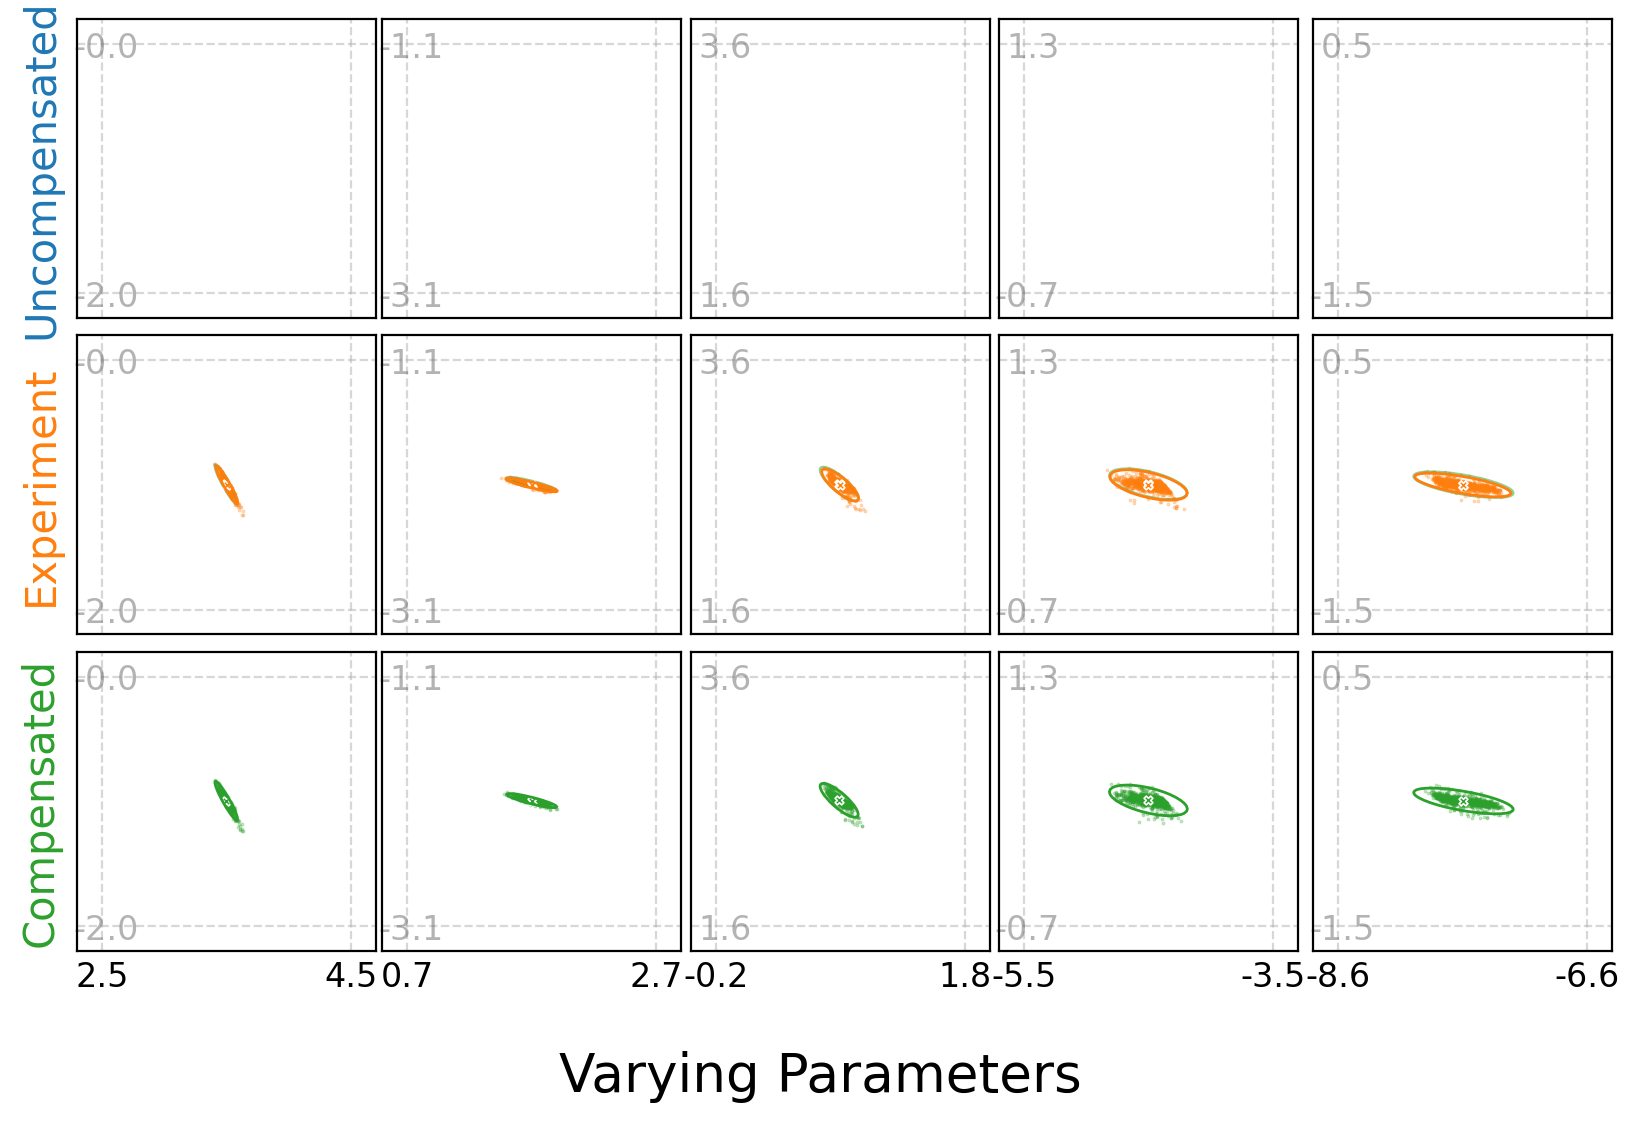

In [6]:
fig = plot_param_tensors(loss_min_params[:5, :1], uncompensated_parameters_selected[:5, :1].squeeze(-2), engine = engine, ray_parameter_container=model.input_parameter_container, compensated_parameters=compensated_parameters_selected[:5, :1].squeeze(-2))
plt.savefig(os.path.join(outputs_dir,'fixed_plot.png'), bbox_inches='tight', pad_inches = 0.1)

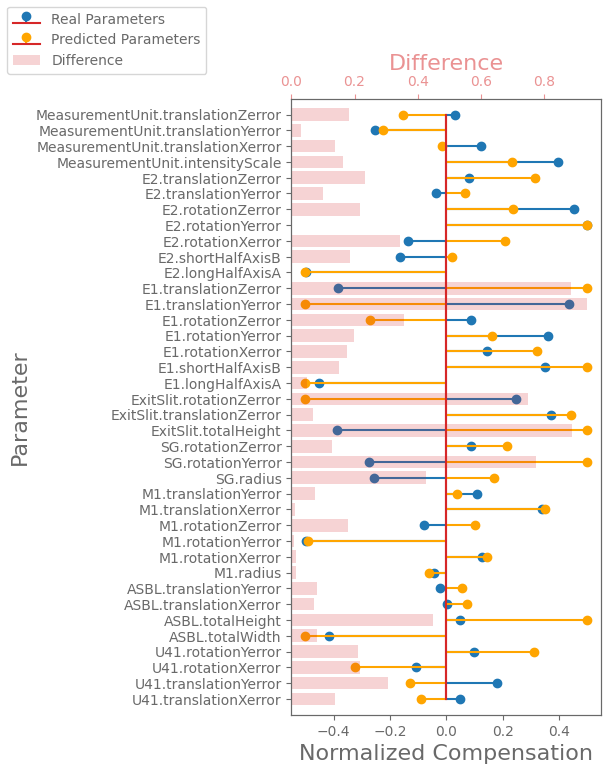

In [23]:
predicted_params = model.unscale_offset((loss_min_params - uncompensated_parameters_selected.squeeze()))[0, 0]#(loss_min_params - compensated_parameters_selected.squeeze())[0][0]
real_params = offsets_selected[0].cpu()
labels = [key for key, value in model.input_parameter_container.items() if isinstance(value, MutableParameter)]
labels = new_label_names(labels)
Plot.plot_normalized_param_comparison(
    predicted_params=predicted_params.cpu(),
    labels= labels,
    real_params=real_params,
)
plt.savefig(os.path.join(outputs_dir,'parameters_comparison.pdf'), bbox_inches='tight', pad_inches = 0)

# Examine 10000 problems

In [23]:
offsets_list, uncompensated_parameters_list, compensated_parameters_list = generate_n_offset_problems(model, 10000, initial_seed=seed)

  0%|          | 0/10000 [00:00<?, ?it/s]

min-entry tensor(-0.0307) max-entry tensor(0.0374)


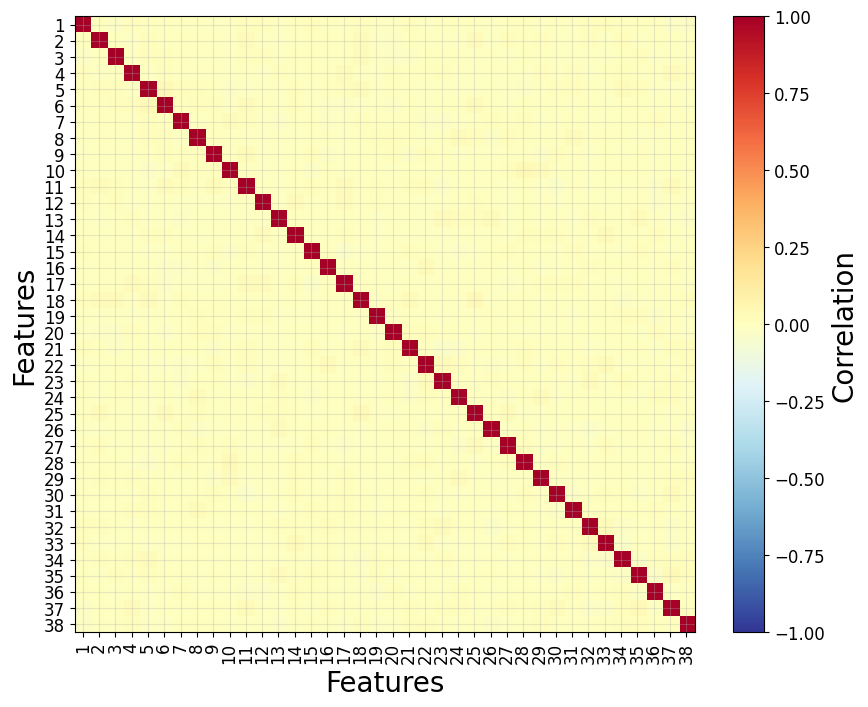

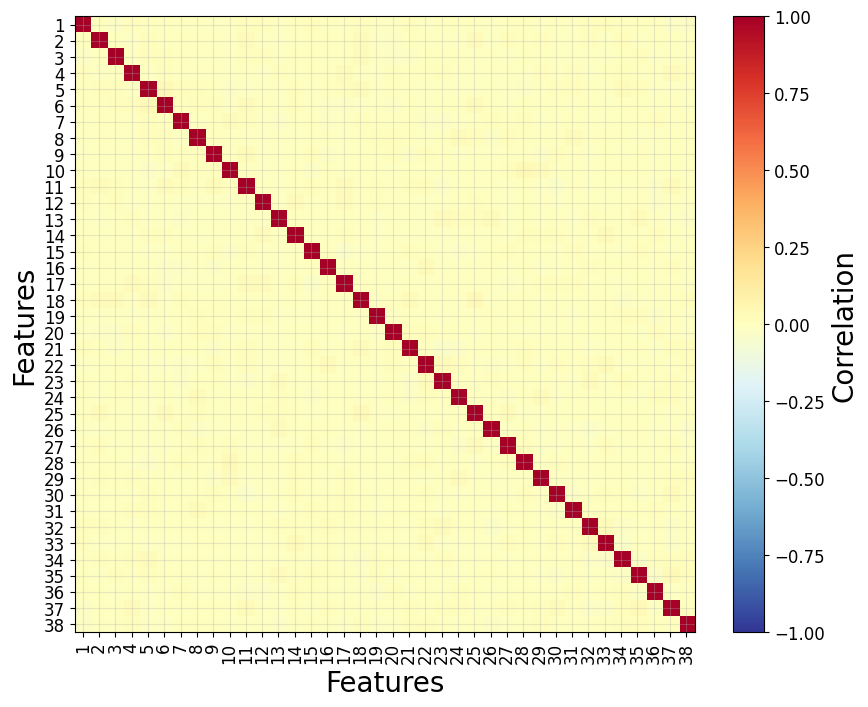

In [84]:
labels = [key for key, value in model.input_parameter_container.items() if isinstance(value, MutableParameter)]
labels = new_label_names(labels)
print(" ".join(f"({i+1}) {label}" for i, label in enumerate(labels)))
labels = [str(i+1) for i in range(len(labels))]
correlation_matrix(offsets_list, labels, "offsets", outputs_dir=outputs_dir)

min-entry tensor(-0.6428) max-entry tensor(0.6090)


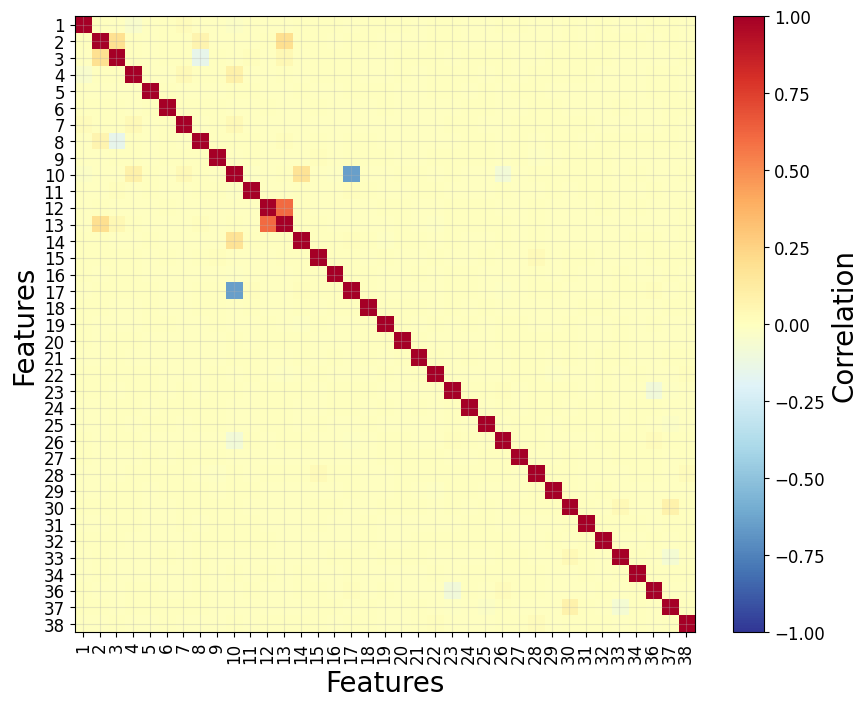

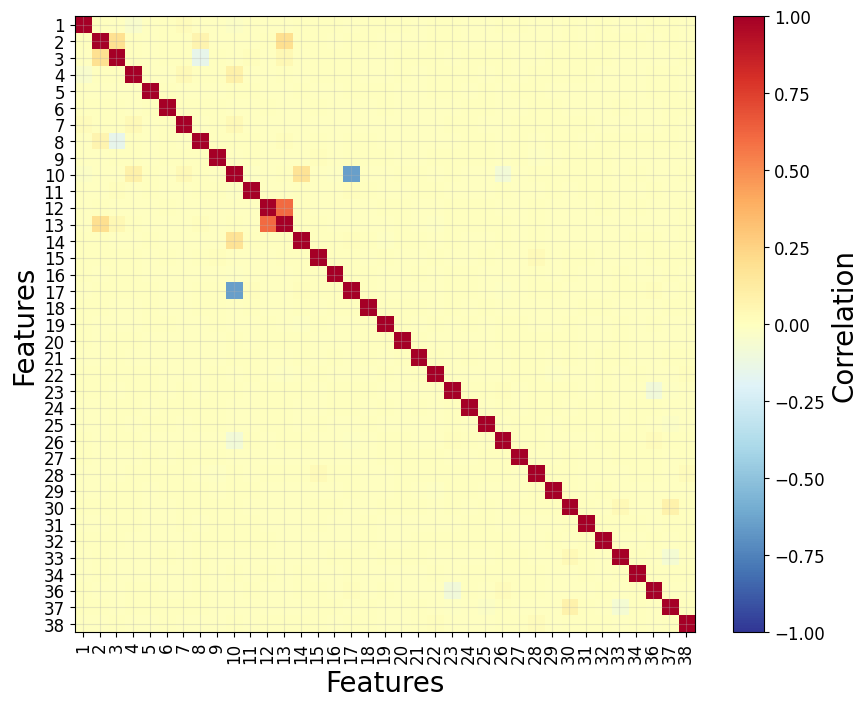

In [85]:
stacked_uncompensated_parameters = torch.vstack([entry[:, 0, 0, :] for entry in uncompensated_parameters_list])
stacked_uncompensated_parameters_except_intensity_scale = torch.cat((stacked_uncompensated_parameters[:, :34], stacked_uncompensated_parameters[:, 35:]), dim=1)
#labels = [key for key, value in model.input_parameter_container.items() if isinstance(value, MutableParameter)]
#labels = new_label_names(labels)
labels_except_intensity_scale = labels[:34]+labels[35:]
correlation_matrix(stacked_uncompensated_parameters_except_intensity_scale, labels_except_intensity_scale, "uncompensated parameters", outputs_dir=outputs_dir)

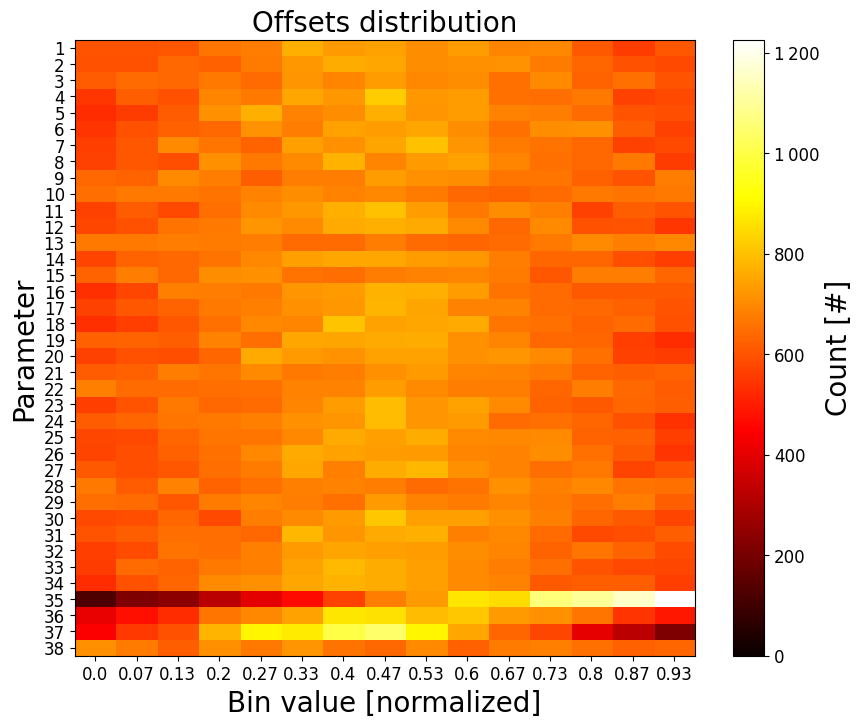

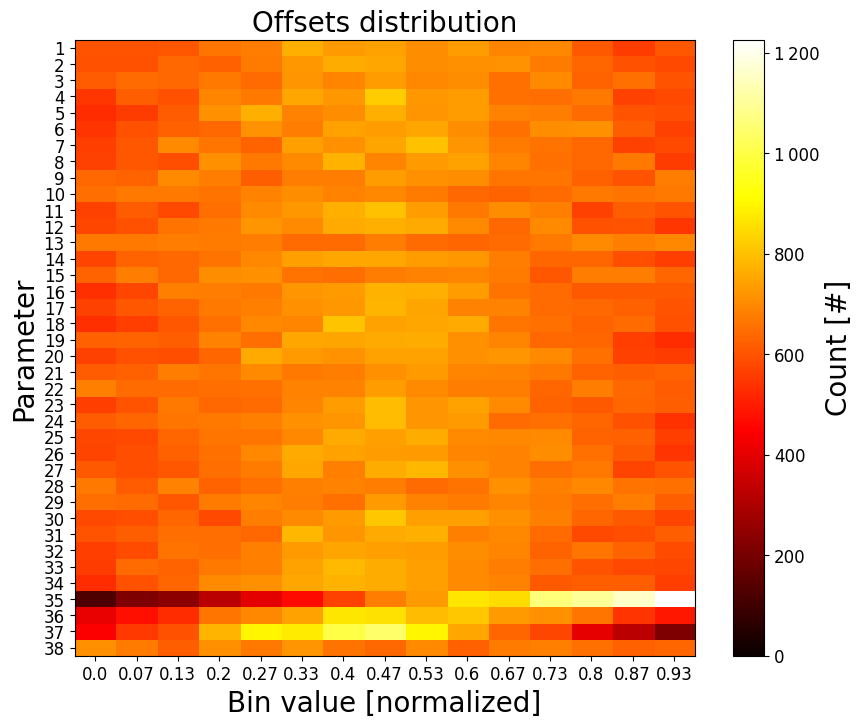

In [99]:
#labels = [key for key, value in model.input_parameter_container.items() if isinstance(value, MutableParameter)]
#labels = new_label_names(labels)
correlation_plot(offsets_list, labels, label="Offsets", outputs_dir=outputs_dir)

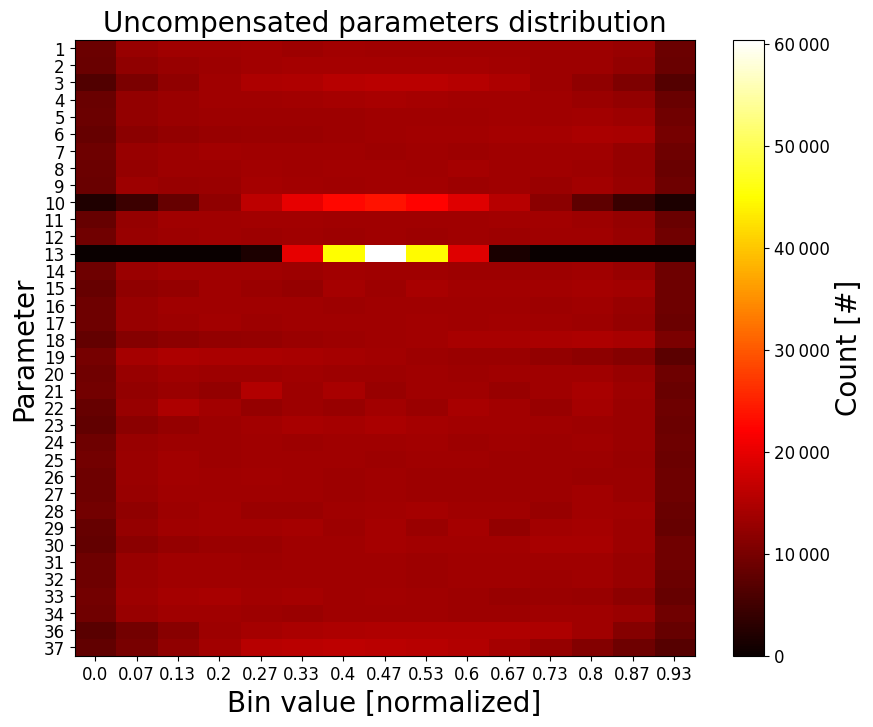

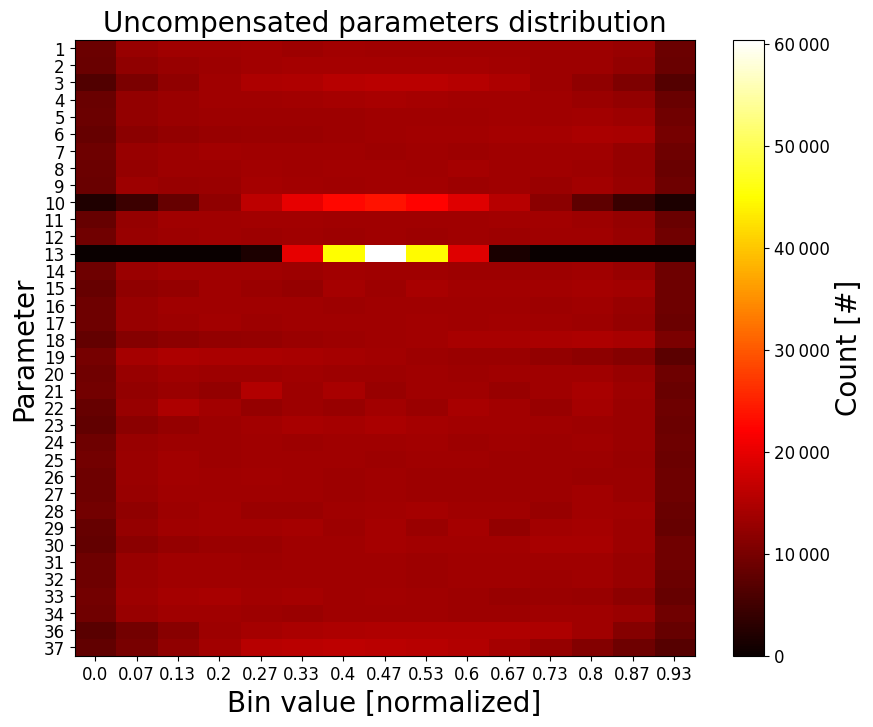

In [100]:
uncompensated_parameters_stack = torch.vstack([entry[:, 0, 0, :] for entry in uncompensated_parameters_list])
stacked_uncompensated_parameters_except_intensity_scale_z = torch.cat((stacked_uncompensated_parameters[:, :34], stacked_uncompensated_parameters[:, 35:-1]), dim=1)
#labels = new_label_names(labels)
labels_except_intensity_scale_z = labels[:34]+labels[35:-1]
correlation_plot(stacked_uncompensated_parameters_except_intensity_scale_z, labels_except_intensity_scale_z, label="Uncompensated parameters", outputs_dir=outputs_dir)

# Compare optimizers

In [ ]:
method_dict = {
    "Powell’s": (
        optimize_powell,
        1000,
        {}
    ),
    "SA": (
        optimize_sa,
        1000,
        {}
    ),
    "GD": (
        optimize_gd,
        1000,
        {"learning_rate": 0.001}
    ),
    "GA_100": (
        optimize_evotorch_ga,
        1000,
        {
            "tournament_size": 3,
            "sbx_crossover_rate": 0.8,
            "num_candidates": 100,
            "mutation_scale": 0.2,
        }
    ),
    "GA_500": (
        optimize_evotorch_ga,
        1000,
        {
            "tournament_size": 3,
            "sbx_crossover_rate": 0.8,
            "num_candidates": 500,
            "mutation_scale": 0.2,
        }
    ),
    "BLOP": (
        optimize_blop,
        1000,
        {"ucb_beta": 10.}
    ),
}

method_evaluation_dict = evaluate_method_dict(method_dict, model, observed_rays, uncompensated_parameters_selected, iterations=1000, repetitions=30, benchmark_repetitions=10, seed=seed)
with open(os.path.join(outputs_dir, "compare_optimizers.pkl"), "wb") as f:
    pickle.dump(method_evaluation_dict, f)

In [ ]:
with open('../../outputs/compare_optimizers.pkl', 'rb') as file: 
    method_evaluation_dict = pickle.load(file) 

In [ ]:
plot_optimizer_iterations(method_evaluation_dict, outputs_dir)

In [ ]:
statistics_dict = statistics(method_evaluation_dict)
print(statistics_dict)
# Generate the LaTeX table
latex_table = generate_latex_table(statistics_dict)

# Output the LaTeX table
print(latex_table)